<font size="+3"><strong>6.2. Clustering with Two Features</strong></font>

In the previous lesson, you explored data from the [Survey of Consumer Finances](https://www.federalreserve.gov/econres/scfindex.htm) (SCF), paying special attention to households that have been turned down for credit or feared being denied credit. In this lesson, we'll build a model to segment those households into distinct clusters, and examine the differences between those clusters. 

In [1]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import wqet_grader
from IPython.display import VimeoVideo
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from teaching_tools.widgets import ClusterWidget, SCFClusterWidget

wqet_grader.init("Project 6 Assessment")


In [2]:
from IPython.display import VimeoVideo

In [3]:
VimeoVideo("713919442", h="7b4cbc1495", width=600)

# Prepare Data

## Import

Just like always, we need to begin by bringing our data into the project. We spent some time in the previous lesson working with a subset of the larger SCF dataset called `"TURNFEAR"`. Let's start with that.

In [3]:
VimeoVideo("713919411", h="fd4fae4013", width=600)

**Task 6.2.1:** Create a `wrangle` function that takes a path of a CSV file as input, reads the file into a DataFrame, subsets the data to households that have been turned down for credit or feared being denied credit in the past 5 years (see `"TURNFEAR"`), and returns the subset DataFrame. 

- [<span id='technique'>Write a function in <span id='tool'>Python</span></span>.](../%40textbook/02-python-advanced.ipynb#Functions)
- [Subset a DataFrame by selecting one or more columns in pandas.](../%40textbook/04-pandas-advanced.ipynb#Subsetting-with-Masks)

In [4]:
def wrangle(filepath):
    df=pd.read_csv(filepath)
    mask=df["TURNFEAR"] == 1
    df = df[mask]
    return df

And now that we've got that taken care of, we'll import the data and see what we've got.

**Task 6.2.2:** Use your `wrangle` function to read the file `SCFP2019.csv.gz` into a DataFrame named `df`.

- [Read a CSV file into a DataFrame using pandas.](../%40textbook/03-pandas-getting-started.ipynb#Working-with-DataFrames)

In [6]:
df = wrangle("data/SCFP2019.csv.gz")
print(df.shape)
df.head()

(4623, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
5,2,21,3790.476607,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
6,2,22,3798.868505,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,3,2,2
7,2,23,3799.468393,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
8,2,24,3788.076005,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
9,2,25,3793.066589,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2


## Explore

We looked at a lot of different features of the `"TURNFEAR"` subset in the last lesson, and the last thing we looked at was the relationship between real estate and debt. To refresh our memory on what that relationship looked like, let's make that graph again.

In [7]:
VimeoVideo("713919351", h="55dc979d55", width=600)

**Task 6.2.3:** Create a scatter plot of that shows the total value of primary residence of a household (`"HOUSES"`) as a function of the total value of household debt (`"DEBT"`). Be sure to label your x-axis as `"Household Debt"`, your y-axis as `"Home Value"`, and use the title `"Credit Fearful: Home Value vs. Household Debt"`.

- [What's a scatter plot?](../%40textbook/06-visualization-matplotlib.ipynb#Scatter-Plots)
- [Create a scatter plot using seaborn.](../%40textbook/09-visualization-seaborn.ipynb#Scatter-Plots)

In [1]:
(df["DEBT"]/1e6).head()

NameError: name 'df' is not defined

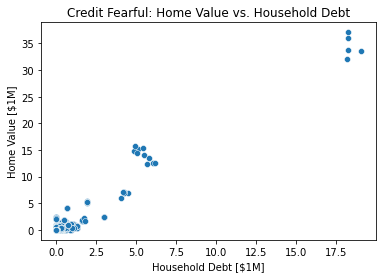

In [13]:
# Plot "HOUSES" vs "DEBT"
sns.scatterplot(x=df["DEBT"]/1e6,y=df["HOUSES"]/1e6)
plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

Remember that graph and its clusters? Let's get a little deeper into it.

## Split

We need to split our data, but we're not going to need target vector or a test set this time around. That's because the model we'll be building involves *unsupervised* learning. It's called *unsupervised* because the model doesn't try to map input to a st of labels or targets that already exist. It's kind of like how humans learn new skills, in that we don't always have models to copy. Sometimes, we just try out something and see what happens. Keep in mind that this doesn't make these models any less useful, it just makes them different.

So, keeping that in mind, let's do the split.

In [14]:
VimeoVideo("713919336", h="775867f48a", width=600)

**Task 6.2.4:** Create the feature matrix `X`. It should contain two features only: `"DEBT"` and `"HOUSES"`.

- [What's a feature matrix?](../%40textbook/14-ml-classification.ipynb#Randomized-Train-Test-split)
- [Subset a DataFrame by selecting one or more columns in pandas.](../%40textbook/04-pandas-advanced.ipynb#Subset-a-DataFrame-by-Selecting-One-or-More-Columns) 

In [16]:
X = df[["DEBT","HOUSES"]]
print(X.shape)
X.head()

(4623, 2)


,DEBT,HOUSES
5,12200.0,0.0
6,12600.0,0.0
7,15300.0,0.0
8,14100.0,0.0
9,15400.0,0.0


# Build Model

Before we start building the model, let's take a second to talk about something called `KMeans`. 

Take another look at the scatter plot we made at the beginning of this lesson. Remember how the datapoints form little clusters? It turns out we can use an algorithm that partitions the dataset into smaller groups.

Let's take a look at how those things work together.

In [17]:
VimeoVideo("713919214", h="028502efe7", width=600)

**Task 6.2.5:** Run the cell below to display the `ClusterWidget`.

- [What's a centroid?](../%40textbook/16-ml-unsupervised-learning.ipynb#Clustering)
- [What's a cluster?](../%40textbook/16-ml-unsupervised-learning.ipynb#Clustering)

In [18]:
cw = ClusterWidget(n_clusters=3)
cw.show()

Take a second and run slowly through all the positions on the slider. At the first position, there's whole bunch of gray datapoints, and if you look carefully, you'll see there are also three stars. Those stars are the **centroids**. At first, their position is set randomly. If you move the slider one more position to the right, you'll see all the gray points change colors that correspond to three clusters.

Since a centroid represents the mean value of all the data in the cluster, we would expect it to fall in the center of whatever cluster it's in. That's what will happen if you move the slider one more position to the right. See how the centroids moved? 

Aha! But since they moved, the datapoints might not be in the right clusters anymore. Move the slider again, and you'll see the data points redistribute themselves to better reflect the new position of the centroids. The new clusters mean that the centroids also need to move, which will lead to the clusters changing again, and so on, until all the datapoints end up in the right cluster with a centroid that reflects the mean value of all those points.

Let's see what happens when we try the same with our `"DEBT"` and `"HOUSES"` data.

In [19]:
VimeoVideo("713919177", h="102616b1c3", width=600)

**Task 6.2.6:** Run the cell below to display the `SCFClusterWidget`.

In [20]:
scfc = SCFClusterWidget(x=df["DEBT"], y=df["HOUSES"], n_clusters=3)
scfc.show()

## Iterate

Now that you've had a chance to play around with the process a little bit, let's get into how to build a model that does the same thing.

In [21]:
VimeoVideo("713919157", h="0b2c3c95f2", width=600)

**Task 6.2.7:** Build a `KMeans` model, assign it to the variable name `model`, and fit it to the training data `X`. 

- [What's k-means clustering?](../%40textbook/16-ml-unsupervised-learning.ipynb#k-means-Clustering)
- [Fit a model to training data in scikit-learn.](../%40textbook/15-ml-regression.ipynb#Fitting-a-Model-to-Training-Data)

<div class="alert alert-info" role="alert">
    <b>Tip:</b> The k-means clustering algorithm relies on random processes, so don't forget to set a <code>random_state</code> for all your models in this lesson.
</div>

In [24]:
# Build model
model = KMeans(n_clusters=3,random_state=42)
# Fit model to data
model.fit(X)

KMeans(n_clusters=3, random_state=42)

And there it is. 42 datapoints spread across three clusters. Let's grab the labels that the model has assigned to the data points so we can start making a new visualization.

In [25]:
VimeoVideo("713919137", h="7eafe805ff", width=600)

**Task 6.2.8:** Extract the labels that your `model` created during training and assign them to the variable `labels`.

- [Access an object in a pipeline in scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Accessing-an-Object-in-a-Pipeline)

In [29]:
labels = model.labels_
labels[-10:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Using the labels we just extracted, let's recreate the scatter plot from before, this time we'll color each point according to the cluster to which the model assigned it.

In [30]:
VimeoVideo("713919104", h="2f6d4285f1", width=600)

**Task 6.2.9:** Recreate the "Home Value vs. Household Debt" scatter plot you made above, but with two changes. First, use seaborn to create the plot. Second, pass your `labels` to the `hue` argument, and set the `palette` argument to `"deep"`. 

- [What's a scatter plot?](../%40textbook/06-visualization-matplotlib.ipynb#Scatter-Plots)
- [Create a scatter plot using seaborn.](../%40textbook/09-visualization-seaborn.ipynb#Scatter-Plots)

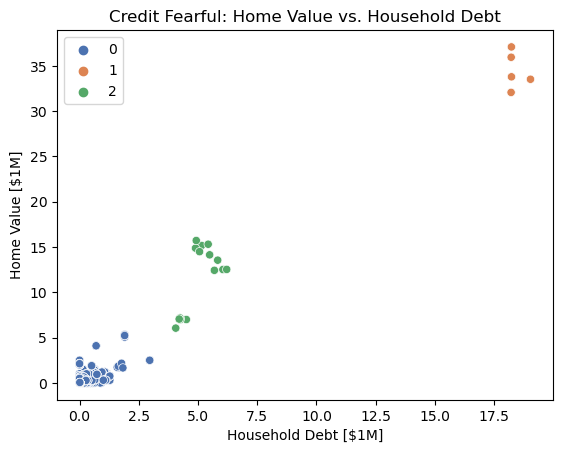

In [32]:
# Plot "HOUSES" vs "DEBT" with hue=label
sns.scatterplot(
    x=df["DEBT"]/1e6,
    y=df["HOUSES"]/1e6,
    hue=labels,
    palette="deep"
)
plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

Nice! Each cluster has its own color. The centroids are still missing, so let's pull those out.

In [33]:
VimeoVideo("713919087", h="9b8635c9a8", width=600)

**Task 6.2.10:** Extract the centroids that your `model` created during training, and assign them to the variable `centroids`. 

- [What's a centroid?](../%40textbook/16-ml-unsupervised-learning.ipynb#Clustering)

In [34]:
centroids = model.cluster_centers_
centroids

array([[   91017.57766674,   116150.29328698],
       [18384100.        , 34484000.        ],
       [ 5065800.        , 11666666.66666667]])

Let's add the centroids to the graph.

In [35]:
VimeoVideo("713919002", h="08cba14f6b", width=600)

**Task 6.2.11:** Recreate the seaborn "Home Value vs. Household Debt" scatter plot you just made, but with one difference: Add the `centroids` to the plot. Be sure to set the centroids color to `"gray"`.

- [What's a scatter plot?](../%40textbook/06-visualization-matplotlib.ipynb#Scatter-Plots)
- [Create a scatter plot using seaborn.](../%40textbook/09-visualization-seaborn.ipynb#Scatter-Plots)

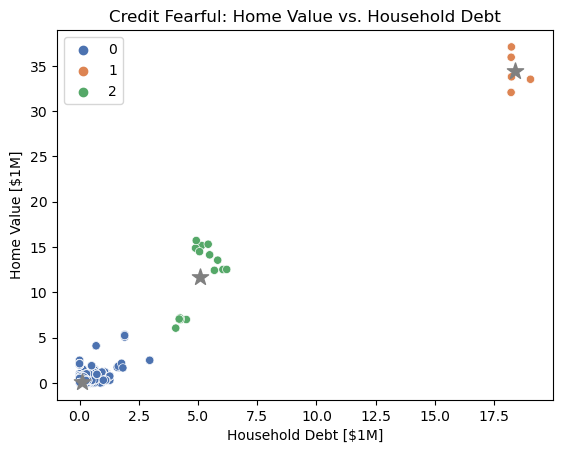

In [43]:
# Plot "HOUSES" vs "DEBT", add centroids
sns.scatterplot(
    x=df["DEBT"]/1e6,
    y=df["HOUSES"]/1e6,
    hue=labels,
    palette="deep"
)
plt.scatter(
x=centroids[:,0]/1e6,
    y=centroids[:,1]/1e6,
    color="gray",
    marker="*",
    s=150
)
plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

That looks great, but let's not pat ourselves on the back just yet. Even though our graph makes it *look* like the clusters are correctly assigned but, as data scientists, we need a numerical evaluation. The data we're using is pretty clear-cut, but if things were a little more muddled, we'd want to run some calculations to make sure we got everything right.

There are two metrics that we'll use to evaluate our clusters. We'll start with **inertia**, which measure the distance between the points *within the same cluster*. 

In [44]:
VimeoVideo("713918749", h="bfc741b1e7", width=600)

<div class="alert alert-info" role="alert">
    <p><b>Question:</b> What do those double bars in the equation mean?</p>
    <p><b>Answer:</b> It's the <i>L2 norm</i>, that is, the non-negative Euclidean distance between each datapoint and its centroid. In Python, it would be something like <code>sqrt((x1-c)**2 + (x2-c)**2) + ...)</code>.</p>
    <p>Many thanks to Aghogho Esuoma Monorien for his comment in the forum! 🙏</p>
</div>

**Task 6.2.12:** Extract the inertia for your `model` and assign it to the variable `inertia`.

- [What's inertia?](../%40textbook/16-ml-unsupervised-learning.ipynb#Inertia)
- [Access an object in a pipeline in scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Accessing-an-Object-in-a-Pipeline)
- [Calculate the inertia for a model in scikit-learn.](../%40textbook/16-ml-unsupervised-learning.ipynb#Inertia)

In [46]:
inertia = model.inertia_
print("Inertia (3 clusters):", inertia)

Inertia (3 clusters): 939554010797059.4


The "best" inertia is 0, and our score is pretty far from that. Does that mean our model is "bad?" Not necessarily. Inertia is a measurement of distance (like mean absolute error from Project 2). This means that the unit of measurement for inertia depends on the unit of measurement of our x- and y-axes. And since `"DEBT"` and `"HOUSES"` are measured in tens of millions of dollars, it's not surprising that inertia is so large. 

However, it would be helpful to have metric that was easier to interpret, and that's where **silhouette score** comes in. Silhouette score measures the distance *between different clusters*. It ranges from -1 (the worst) to 1 (the best), so it's easier to interpret than inertia. 

In [47]:
VimeoVideo("713918501", h="0462c4784a", width=600)

**Task 6.2.13:** Calculate the silhouette score for your model and assign it to the variable `ss`.

- [What's silhouette score?](../%40textbook/16-ml-unsupervised-learning.ipynb#Silhouette-Score)
- [Calculate the silhouette score for a model in scikit-learn.](../%40textbook/16-ml-unsupervised-learning.ipynb#Silhouette-Score)

In [48]:
ss = silhouette_score(X,model.labels_)
print("Silhouette Score (3 clusters):", ss)

Silhouette Score (3 clusters): 0.9768842462944348


Outstanding! 0.976 is pretty close to 1, so our model has done a good job at identifying 3 clusters that are far away from each other.

It's important to remember that these performance metrics are the result of the number of clusters we told our model to create. In unsupervised learning, the number of clusters is hyperparameter that you set before training your model. So what would happen if we change the number of clusters? Will it lead to better performance? Let's try!

In [49]:
VimeoVideo("713918420", h="e16f3735c7", width=600)

**Task 6.2.14:** Use a `for` loop to build and train a K-Means model where `n_clusters` ranges from 2 to 12 (inclusive). Each time a model is trained, calculate the inertia and add it to the list `inertia_errors`, then calculate the silhouette score and add it to the list `silhouette_scores`.

- [Write a `for` loop in Python.](../%40textbook/01-python-getting-started.ipynb#Working-with-for-Loops)
- [Calculate the inertia for a model in scikit-learn.](../%40textbook/16-ml-unsupervised-learning.ipynb#Inertia)
- [Calculate the silhouette score for a model in scikit-learn.](../%40textbook/16-ml-unsupervised-learning.ipynb#Silhouette-Score)

In [54]:
n_clusters = range(2,13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    #Build Model
    model=KMeans(n_clusters=k,random_state=42)
    #Train model
    model.fit(X)
    inertia_errors.append(model.inertia_)
    #Calculate ss
    silhouette_scores.append(silhouette_score(X,model.labels_))
    
print("Inertia:", inertia_errors)
print()
print("Silhouette Scores:", silhouette_scores)

Inertia: [3018038313336857.5, 939554010797059.4, 546098841715646.25, 309310386410913.3, 235243397481784.3, 182225729179703.53, 150670779013790.4, 114321995931021.89, 100340259483919.02, 86229997033602.88, 74757234072100.36]

Silhouette Scores: [0.9855099957519555, 0.9768842462944348, 0.9490311483406091, 0.839330043242819, 0.7287406719898627, 0.726989114305748, 0.7263840026889208, 0.7335125606476427, 0.692157992955073, 0.6949309528556856, 0.6951831031001252]


Now that we have both performance metrics for several different settings of `n_clusters`, let's make some line plots to see the relationship between the number of clusters in a model and its inertia and silhouette scores.

In [55]:
VimeoVideo("713918224", h="32ff34ffa1", width=600)

**Task 6.2.15:** Create a line plot that shows the values of `inertia_errors` as a function of `n_clusters`. Be sure to label your x-axis `"Number of Clusters"`, your y-axis `"Inertia"`, and use the title `"K-Means Model: Inertia vs Number of Clusters"`.

- [Create a line plot in Matplotlib.](../%40textbook/07-visualization-pandas.ipynb#Line-Plots)

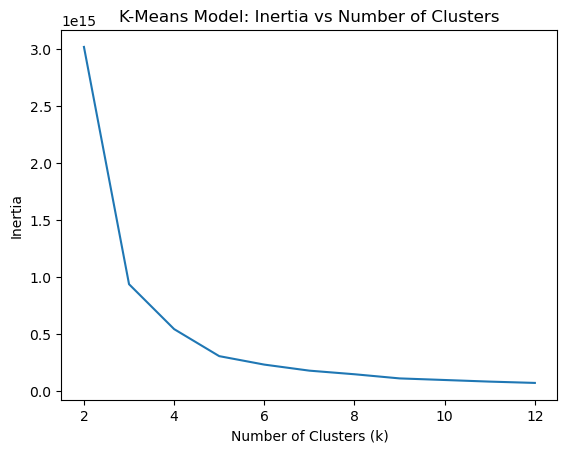

In [58]:
# Plot `inertia_errors` by `n_clusters`
plt.plot(n_clusters,inertia_errors)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("K-Means Model: Inertia vs Number of Clusters");

What we're seeing here is that, as the number of clusters increases, inertia goes down. In fact, we could get inertia to 0 if we told our model to make 4,623 clusters (the same number of observations in `X`), but those clusters wouldn't be helpful to us.

The trick with choosing the right number of clusters is to look for the "bend in the elbow" for this plot. In other words, we want to pick the point where the drop in inertia becomes less dramatic and the line begins to flatten out. In this case, it looks like the sweet spot is 4 or 5. 

Let's see what the silhouette score looks like. 

In [62]:
VimeoVideo("713918153", h="3f3a1312d2", width=600)

**Task 6.2.16:** Create a line plot that shows the values of `silhouette_scores` as a function of `n_clusters`. Be sure to label your x-axis `"Number of Clusters"`, your y-axis `"Silhouette Score"`, and use the title `"K-Means Model: Silhouette Score vs Number of Clusters"`.

- [Create a line plot in Matplotlib.](../%40textbook/07-visualization-pandas.ipynb#Line-Plots)

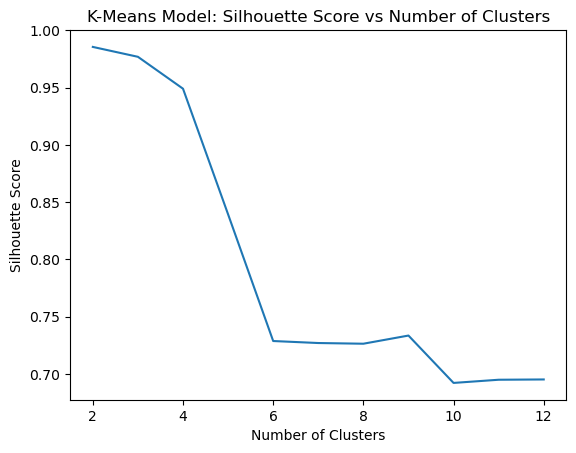

In [61]:
# Plot `silhouette_scores` vs `n_clusters`
plt.plot(n_clusters,silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("K-Means Model: Silhouette Score vs Number of Clusters");

Note that, in contrast to our inertia plot, bigger is better. So we're not looking for a "bend in the elbow" but rather a number of clusters for which the silhouette score still remains high. We can see that silhouette score drops drastically beyond 4 clusters. Given this and what we saw in the inertia plot, it looks like the optimal number of clusters is 4. 

Now that we've decided on the final number of clusters, let's build a final model.

In [63]:
VimeoVideo("713918108", h="e6aa88569e", width=600)

**Task 6.2.17:** Build and train a new k-means model named `final_model`. Use the information you gained from the two plots above to set an appropriate value for the `n_clusters` argument. Once you've built and trained your model, submit it to the grader for evaluation. 

- [Fit a model to training data in scikit-learn.](../%40textbook/15-ml-regression.ipynb#Fitting-a-Model-to-Training-Data)

In [64]:
# Build model
final_model = KMeans(n_clusters=4,random_state=42)
# Fit model to data
final_model.fit(X)

KMeans(n_clusters=4, random_state=42)

In [65]:

wqet_grader.grade("Project 6 Assessment", "Task 6.2.17", final_model)

(In case you're wondering, we don't need an *Evaluate* section in this notebook because we don't have any test data to evaluate our model with.)

# Communicate

In [66]:
VimeoVideo("713918073", h="3929b58011", width=600)

**Task 6.2.18:** Create one last "Home Value vs. Household Debt" scatter plot that shows the clusters that your `final_model` has assigned to the training data. 

- [What's a scatter plot?](../%40textbook/06-visualization-matplotlib.ipynb#Scatter-Plots)
- [Create a scatter plot using Matplotlib.](../%40textbook/06-visualization-matplotlib.ipynb#Scatter-Plots)

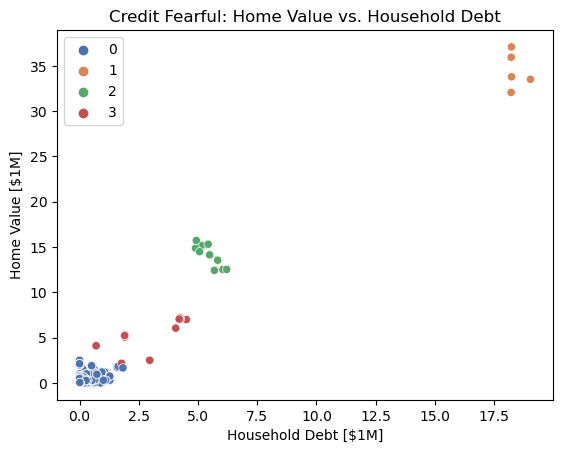

In [69]:
# Plot "HOUSES" vs "DEBT" with final_model labels
sns.scatterplot(
x=df["DEBT"]/1e6,
    y=df["HOUSES"]/1e6,
    hue=final_model.labels_,
    palette="deep"
)
plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

Nice! You can see all four of our clusters, each differentiated from the rest by color.

We're going to make one more visualization, converting the cluster analysis we just did to something a little more actionable: a side-by-side bar chart. In order to do that, we need to put our clustered data into a DataFrame.

In [70]:
VimeoVideo("713918023", h="110156bd98", width=600)

**Task 6.2.19:** Create a DataFrame `xgb` that contains the mean `"DEBT"` and `"HOUSES"` values for each of the clusters in your `final_model`.

- [Access an object in a pipeline in scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Accessing-an-Object-in-a-Pipeline)
- [Aggregate data using the groupby method in pandas.](../%40textbook/04-pandas-advanced.ipynb#Series-and-Groupby)
- [Create a DataFrame from a Series in pandas.](../%40textbook/04-pandas-advanced.ipynb#Series-and-Groupby)

In [72]:
xgb = X.groupby(final_model.labels_).mean()
xgb

,DEBT,HOUSES
0,8.488629e+04,1.031872e+05
1,1.838410e+07,3.448400e+07
2,5.472800e+06,1.407400e+07
3,2.420929e+06,4.551429e+06


In [74]:
final_model.cluster_centers_

array([[   84886.28951384,   103187.22476563],
       [18384100.        , 34484000.        ],
       [ 5472800.        , 14074000.        ],
       [ 2420928.57142857,  4551428.57142857]])

Before you move to the next task, print out the `cluster_centers_` for your `final_model`. Do you see any similarities between them and the DataFrame you just made? Why do you think that is?

In [75]:
VimeoVideo("713917740", h="bcc496c2d9", width=600)

**Task 6.2.20:** Create a side-by-side bar chart from `xgb` that shows the mean `"DEBT"` and `"HOUSES"` values for each of the clusters in your `final_model`. For readability, you'll want to divide the values in `xgb` by 1 million. Be sure to label the x-axis `"Cluster"`, the y-axis `"Value [$1 million]"`, and use the title `"Mean Home Value & Household Debt by Cluster"`.

- [Create a bar chart using pandas.](../%40textbook/07-visualization-pandas.ipynb#Bar-Charts)

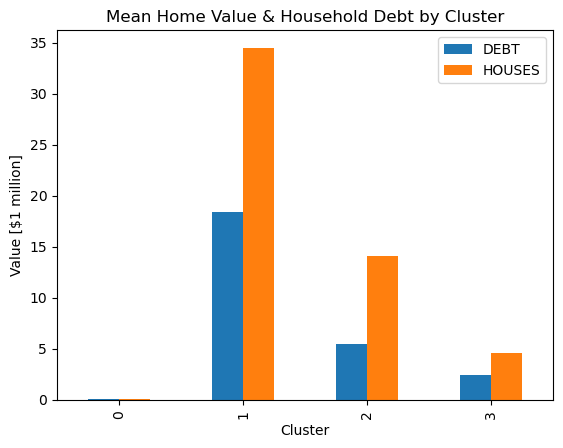

In [79]:
# Create side-by-side bar chart of `xgb`
(xgb/1e6).plot(kind="bar")
plt.xlabel("Cluster")
plt.ylabel("Value [$1 million]")
plt.title("Mean Home Value & Household Debt by Cluster");

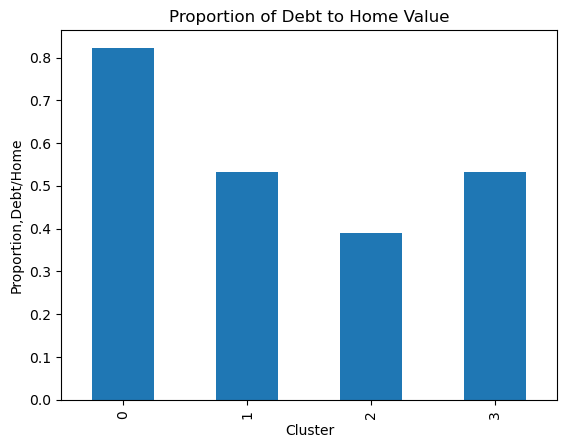

In [84]:
(xgb["DEBT"]/xgb["HOUSES"]).plot(
kind="bar",
    xlabel="Cluster",
    ylabel="Proportion,Debt/Home",
    title="Proportion of Debt to Home Value"
);

In this plot, we have our four clusters spread across the x-axis, and the dollar amounts for home value and household debt on the y-axis. 

The first thing to look at in this chart is the different mean home values for the five clusters. Clusters 0 represents households with small to moderate home values, clusters 2 and 3 have high home values, and cluster 1 has extremely high values. 

The second thing to look at is the proportion of debt to home value. In clusters 1 and 3, this proportion is around 0.5. This suggests that these groups have a moderate amount of untapped equity in their homes. But for group 0, it's almost 1, which suggests that the largest source of household debt is their mortgage. Group 2 is unique in that they have the smallest proportion of debt to home value, around 0.4.

This information could be useful to financial institution that want to target customers with products that would appeal to them. For instance, households in group 0 might be interested in refinancing their mortgage to lower their interest rate. Group 2 households could be interested in a [home equity line of credit](https://www.investopedia.com/home-equity-line-of-credit-heloc-definition-5217473) because they have more equity in their homes. And the bankers, Bill Gates, and Beyoncés in group 1 might want white-glove personalized wealth management. 

---
Copyright © 2022 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
